In [1]:
import pandas as pd
import numpy as np
import glob
from typing import Any
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
folders = glob.glob('*')
folder = folders[-5]
print(folder)

def load_polis_data(folder):
    # read in summary, stats-history, votes, comments, and participants-votes
    files = glob.glob(f'{folder}/*.csv')
    file_map = {}
    for file in files:
        file_name = file.split('/')[-1].split('.')[0]
        # if summary, no header
        if file_name == 'summary':
            file_map[file_name] = pd.read_csv(file, header=None)
        else:
            file_map[file_name] = pd.read_csv(file)
    return file_map
data_map = load_polis_data(folder)

votes = data_map['votes']
voter_ids = np.sort(votes['voter-id'].unique())
voter_map = {voter_id: i for i, voter_id in enumerate(voter_ids)}
comment_ids = np.sort(votes['comment-id'].unique())
comment_map = {comment_id: i for i, comment_id in enumerate(comment_ids)}
# make sparse matrix with votes
vote_matrix = np.full((len(voter_ids), len(comment_ids)), np.nan)
for _, row in votes.iterrows():
    voter_id = row['voter-id']
    comment_id = row['comment-id']
    vote = row['vote']
    vote_matrix[voter_map[voter_id], comment_map[comment_id]] = vote

vote_matrix


scoop-hivemind.taxes


array([[nan,  1., nan, ..., nan, nan, nan],
       [-1.,  1., -1., ..., nan, nan, nan],
       [-1., -1.,  1., ..., nan, nan, nan],
       ...,
       [-1.,  1., -1., ..., nan, nan, nan],
       [ 1.,  1., -1., ..., nan, nan, nan],
       [-1., -1.,  1., ..., nan, nan, nan]])

In [3]:
def kmeans_sparse(
    X, 
    k, 
    max_iter=100, 
    tol=1e-4, 
    fill_empty='zero',  # or 'global_mean'
    random_state=None
):
    """
    Perform k-means clustering on data that may contain NaN values.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data, can contain NaN entries.
    k : int
        Number of clusters.
    max_iter : int, optional
        Maximum number of iterations.
    tol : float, optional
        Tolerance for convergence based on centroid shift.
    fill_empty : {'zero', 'global_mean'}, optional
        How to fill a centroid's feature if no cluster members have a non-NaN value
        in that feature:
          - 'zero': use 0.0
          - 'global_mean': use the global mean (ignoring NaNs) of that feature
    random_state : int, optional
        Seed for reproducible centroid initialization.
        
    Returns
    -------
    labels : ndarray of shape (n_samples,)
        The final cluster assignment of each sample.
    centroids : ndarray of shape (k, n_features)
        The final cluster centroids.
    """

    np.random.seed(random_state)
    n_samples, n_features = X.shape
    
    # -- Precompute global means per feature (ignoring NaNs), if needed
    if fill_empty == 'global_mean':
        global_means = np.nanmean(X, axis=0)  # shape = (n_features,)
    else:
        global_means = None
    
    # -- Initialize centroids by picking k random valid (non-NaN in at least one dim) rows
    #    (Alternatively, you could pick them purely at random or by some smarter initialization.)
    valid_rows = ~np.isnan(X).all(axis=1)  # rows that have at least one non-NaN
    valid_indices = np.where(valid_rows)[0]
    if len(valid_indices) < k:
        raise ValueError("Not enough valid data rows to initialize k centroids.")
    init_indices = np.random.choice(valid_indices, size=k, replace=False)
    centroids = X[init_indices].copy()
    
    # Where entire row is NaN, fill with global means or zero to avoid NaNs in centroids
    if fill_empty == 'global_mean' and global_means is not None:
        nan_mask = np.isnan(centroids)
        centroids[nan_mask] = np.take(global_means, np.where(nan_mask)[1])
    else:
        # fill NaN with zeros in the chosen centroid rows
        centroids = np.nan_to_num(centroids, nan=0.0)

    # -- Helper function: compute distance ignoring NaNs
    def sparse_distance_matrix(X, centroids):
        """
        Compute distance from each point in X to each centroid in 'centroids',
        ignoring NaNs in X (and in centroids, if any).
        
        Returns dist of shape (n_samples, k).
        """
        n_samples = X.shape[0]
        k = centroids.shape[0]
        dist = np.empty((n_samples, k), dtype=float)
        
        for i in range(k):
            # For each centroid, compute distance ignoring NaNs
            # We'll do a mask for which entries are not NaN in X and centroid
            centroid = centroids[i]
            # Expand to shape (n_samples, n_features) for broadcast
            diff = X - centroid  
            
            # Mark places where X is NaN
            nan_mask_x = np.isnan(X)
            # Mark places where centroid is NaN (should be rare if we fill them in)
            nan_mask_c = np.isnan(centroid)
            
            # Combine masks: ignore features where X or centroid is NaN
            valid_mask = ~(nan_mask_x | nan_mask_c)
            
            # squared distances, ignoring invalid features
            # diff[valid_mask] picks out all valid positions across all samples
            # but we have to do this carefully by row
            # A straightforward way is to do row by row:
            sqdist = np.zeros(n_samples, dtype=float)
            for r in range(n_samples):
                valid = valid_mask[r]
                sqdist[r] = np.sum(diff[r, valid] ** 2)
            
            dist[:, i] = np.sqrt(sqdist)
        
        return dist
    
    # -- Main k-means loop
    labels = np.zeros(n_samples, dtype=int)
    for iteration in range(max_iter):
        old_centroids = centroids.copy()
        
        # 1) Assign each point to the nearest centroid
        dists = sparse_distance_matrix(X, centroids)
        labels = np.argmin(dists, axis=1)
        
        # 2) Recompute centroids
        for cluster_id in range(k):
            # Extract points belonging to this cluster
            cluster_mask = (labels == cluster_id)
            X_cluster = X[cluster_mask]  # shape: (num_points_in_cluster, n_features)
            
            new_centroid = np.zeros(n_features, dtype=float)
            
            if len(X_cluster) == 0:
                # If no points in this cluster, leave centroid as old one or re-init
                # (You could do something else, e.g., re-initialize randomly.)
                new_centroid = old_centroids[cluster_id]
            else:
                # For each feature, compute mean ignoring NaNs
                for f in range(n_features):
                    feature_values = X_cluster[:, f]
                    # Keep only non-NaN
                    valid_vals = feature_values[~np.isnan(feature_values)]
                    
                    if len(valid_vals) > 0:
                        new_centroid[f] = np.mean(valid_vals)
                    else:
                        # No data in this feature for the cluster
                        if fill_empty == 'zero':
                            new_centroid[f] = 0.0
                        elif fill_empty == 'global_mean' and global_means is not None:
                            new_centroid[f] = global_means[f]
                        else:
                            new_centroid[f] = 0.0  # fallback default
                            
            centroids[cluster_id] = new_centroid
        
        # 3) Check for convergence (based on centroid movement)
        centroid_shift = np.sqrt(np.sum((centroids - old_centroids) ** 2))
        if centroid_shift < tol:
            break
    
    return labels, centroids

def get_sparse_mean(X):
    # get the mean of each column, ignoring NaNs
    return np.nanmean(X, axis=0)


# Run k-means with k=2
# labels, centroids = kmeans_sparse(A, k=2, fill_empty='global_mean', random_state=42)
n_clusters = 3
labels, centroids = kmeans_sparse(vote_matrix, k=n_clusters, fill_empty='global_mean', random_state=42)
marginal_mean = (get_sparse_mean(vote_matrix) + 1) / 2
marginal_counts = np.sum(~np.isnan(vote_matrix), axis=0)

In [4]:
prior_weight = 1
prior = np.full(len(marginal_counts), 0.5)

marginal_posterior = (marginal_counts * marginal_mean + prior_weight * prior) / (marginal_counts + prior_weight)
marginal_posterior

array([0.20307167, 0.51027397, 0.37108014, 0.64795918, 0.39175258,
       0.19377163, 0.13888889, 0.66952055, 0.24914676, 0.296875  ,
       0.1384083 , 0.25      , 0.33838384, 0.30795848, 0.25      ,
       0.30040323, 0.46122449, 0.15560166, 0.16806723, 0.24896266,
       0.22      , 0.208     , 0.55204461, 0.26819923, 0.69498069,
       0.67735849, 0.76346154, 0.79182879, 0.81730769, 0.81153846,
       0.80876494, 0.81417625, 0.8229572 , 0.69322709, 0.83596838,
       0.77777778, 0.61046512, 0.86872587, 0.85882353, 0.96031746,
       0.93307087, 0.6155303 , 0.41294643, 0.76680672, 0.67540323,
       0.7811245 , 0.96170213, 0.75      , 0.75      , 0.75      ,
       0.76666667, 0.75      , 0.75      , 0.75      , 0.71761658,
       0.12285714, 0.75      , 0.75      , 0.75      , 0.75      ,
       0.75      , 0.37172775, 0.75      , 0.75      , 0.63383838,
       0.34574468, 0.84577114, 0.75      , 0.75      , 0.75      ,
       0.75      , 0.75      , 0.75      , 0.75      , 0.22625

In [5]:
# normalize centroids to binary 0-1
cluster_ps = (centroids + 1) / 2
# marginal_ps = (marginal_mean + 1) / 2
cluster_counts = np.stack([np.sum(~np.isnan(vote_matrix[labels == i]), axis=0) for i in range(centroids.shape[0])])
cluster_sizes = np.array([np.sum(labels == i) for i in range(centroids.shape[0])])
p_cluster = cluster_sizes / len(labels)

# TODO - possibly add weight proportional to size of cluster instead of uniform
cluster_posteriors = (prior_weight * p_cluster).reshape(-1, 1) * np.repeat(prior.reshape(1, -1), cluster_counts.shape[0], axis=0)

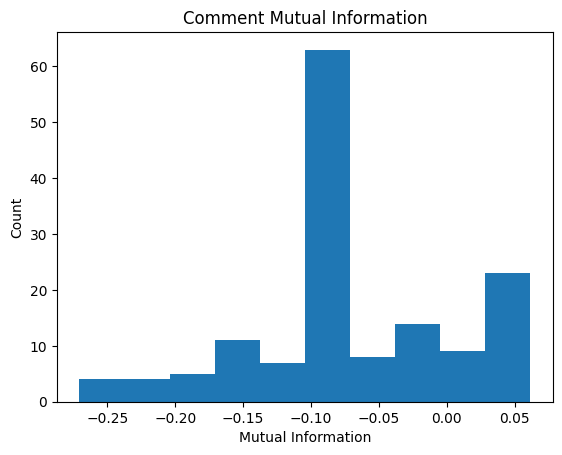

In [22]:
marginal_entropy = -(marginal_posterior * np.log(marginal_posterior))
conditional_entropy = (-cluster_posteriors * np.log(cluster_posteriors) * p_cluster.reshape(-1, 1)).sum(axis=0)
comment_mutual_info = marginal_entropy - conditional_entropy
# argsort comment_mutual_info descending
sorted_comments = np.argsort(comment_mutual_info)[::-1]
plt.hist(comment_mutual_info)
plt.title('Comment Mutual Information')
plt.xlabel('Mutual Information')
plt.ylabel('Count')
plt.show()

(array([1., 1., 0., 0., 1., 2., 1., 2., 2., 5.]),
 array([0.04323006, 0.0450606 , 0.04689114, 0.04872168, 0.05055221,
        0.05238275, 0.05421329, 0.05604383, 0.05787437, 0.05970491,
        0.06153545]),
 <BarContainer object of 10 artists>)

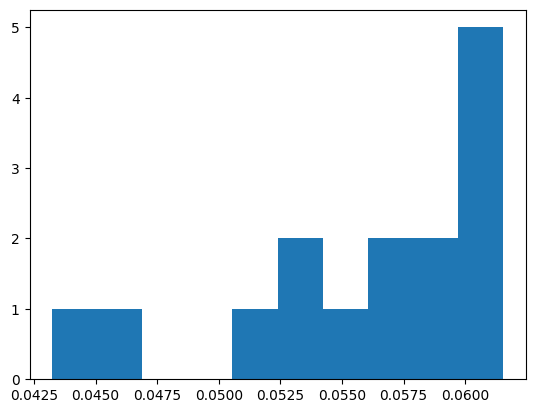

In [8]:
# marginal_entropy - conditional_entropy
sorted_comments
max_comments_to_include = 15
top_comment_inds = sorted_comments[:max_comments_to_include]
top_comment_ids = comment_ids[top_comment_inds]
top_comment_ids
plt.hist(comment_mutual_info[top_comment_inds])

In [9]:
# get dataset description
# summary_data = file_map['summary']
summary_data = data_map['summary']
# flip so [0] is column and [1] is entry
summary_data = summary_data.T
# make first row the header
summary_data.columns = summary_data.iloc[0]
summary_data = summary_data.iloc[1:]
# summary_data['topic'].iloc[0]
topic = summary_data['topic'].iloc[0]
summary_data
# dataset.ratings
# print(summary_data['conversation-description'].iloc[0])
description = summary_data['conversation-description'].iloc[0]

cluster_alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
prefix = f"""The following is output from an online digital town hall. People have been clustered into {n_clusters} groups based on their voting history. Based on the cluster vote distributions per comment, give a 1-2 sentence description of each cluster. First, reason about the differences, and then give the descriptions, formatted like so:\n""" + '\n'.join([f'Reasoning about Cluster {cluster_alpha[i]}: <paragraph or so reasoning about the differences between this cluster and the others>\nCluster {cluster_alpha[i]} description: <1-2 sentence description>' for i in range(n_clusters)]) + " \n\n"""

prompt = prefix + f"Topic: {topic}\nDescription: {description}"

prompt += "\n\nCluster sizes (number of participants):\n"
for i in range(n_clusters):
    prompt += f"Cluster {cluster_alpha[i]}: {cluster_sizes[i]}\n"
prompt += "\n"
prompt += "Most divergent comments:\n"

postfix = "Based on the above, give a 1-2 sentence description of each cluster."
print(prompt)

The following is output from an online digital town hall. People have been clustered into 3 groups based on their voting history. Based on the cluster vote distributions per comment, give a 1-2 sentence description of each cluster. First, reason about the differences, and then give the descriptions, formatted like so:
Reasoning about Cluster A: <paragraph or so reasoning about the differences between this cluster and the others>
Cluster A description: <1-2 sentence description>
Reasoning about Cluster B: <paragraph or so reasoning about the differences between this cluster and the others>
Cluster B description: <1-2 sentence description>
Reasoning about Cluster C: <paragraph or so reasoning about the differences between this cluster and the others>
Cluster C description: <1-2 sentence description> 

Topic: Tax HiveMind Window
Description: This HiveMind has *closed* so it's no longer possible to vote on statements or add statements for others to vote on. You can still *explore the opini

In [10]:
answer_map = {
    1: "Agree",
    -1: "Disagree",
    0: "Pass"
}
comments = data_map['comments'].copy()

comments_string = ""
for comment_id in top_comment_ids:
    comments_string += f"Comment: {comments.iloc[comment_id]['comment-body'].strip()}\n"
    # comments_string += f"Vote: {comments.iloc[comment_id]['vote']}\n\n"
    for cluster_id in range(n_clusters):
        cluster_voter_ids = voter_ids[labels == cluster_id]
        comment_cluster_votes = votes[votes['comment-id'] == comment_id]
        comment_cluster_votes = comment_cluster_votes[comment_cluster_votes['voter-id'].isin(cluster_voter_ids)]
        comment_cluster_dist = dict(comment_cluster_votes['vote'].value_counts(normalize=True))
        comment_cluster_count = len(comment_cluster_votes)
        # comment_cluster_dist, comment_cluster_count

        comment_cluster_dist_str = {answer_map[k]: int(round(v, 2) * 100) for k, v in comment_cluster_dist.items()}
        full_comment_cluster_dist_str = ", ".join([f"{v}% {k}" for k, v in comment_cluster_dist_str.items()])
        # add total number of votes
        full_comment_cluster_dist_str += f" ({comment_cluster_count} total votes)"
        comments_string += f"Cluster {cluster_alpha[cluster_id]}: {full_comment_cluster_dist_str}\n"
    comments_string += "\n"
# print(comments_string)

full_prompt = '\n'.join([prompt, comments_string, postfix])
print(full_prompt)

The following is output from an online digital town hall. People have been clustered into 3 groups based on their voting history. Based on the cluster vote distributions per comment, give a 1-2 sentence description of each cluster. First, reason about the differences, and then give the descriptions, formatted like so:
Reasoning about Cluster A: <paragraph or so reasoning about the differences between this cluster and the others>
Cluster A description: <1-2 sentence description>
Reasoning about Cluster B: <paragraph or so reasoning about the differences between this cluster and the others>
Cluster B description: <1-2 sentence description>
Reasoning about Cluster C: <paragraph or so reasoning about the differences between this cluster and the others>
Cluster C description: <1-2 sentence description> 

Topic: Tax HiveMind Window
Description: This HiveMind has *closed* so it's no longer possible to vote on statements or add statements for others to vote on. You can still *explore the opini

In [ ]:
import requests
import json
import os

def call_claude_api(prompt, api_key, model="claude-3-7-sonnet-20250219", max_tokens=1000):
    """
    Make a completion request to the Claude API
    
    Args:
        prompt (str): The prompt to complete
        api_key (str): Your Anthropic API key
        model (str): The Claude model to use
        max_tokens (int): Maximum number of tokens to generate
        
    Returns:
        dict: The API response
    """
    
    headers = {
        "x-api-key": api_key,
        "anthropic-version": "2023-06-01",
        "content-type": "application/json"
    }
    
    data = {
        "model": model,
        "max_tokens": max_tokens,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }
    
    response = requests.post(
        "https://api.anthropic.com/v1/messages",
        headers=headers,
        json=data
    )
    
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None
        
    return response.json()

api_key = os.environ.get("ANTHROPIC_API_KEY")

if not api_key:
    print("Please set your ANTHROPIC_API_KEY environment variable")
    # exit(1)
    raise ValueError("Please set your ANTHROPIC_API_KEY environment variable")

# Make the API call
model = "claude-3-7-sonnet-20250219"
response = call_claude_api(full_prompt, api_key, model=model)

if response:
    # Extract the completion text
    completion = response["content"][0]["text"]
    print("\nCompletion from Claude API:")
    print(completion)
    
    # Print additional info
    print("\nModel used:", response.get("model"))
    print("Usage tokens:", response.get("usage", {}))


Completion from Claude API:
# Analysis of Clusters Based on Tax Opinions

Let me analyze the voting patterns across the three clusters to identify their distinct characteristics and perspectives on tax policies.

## Reasoning about Cluster A:
Cluster A shows mixed opinions on most tax issues, often with fairly even splits between agree and disagree positions. They are somewhat supportive of progressive taxation (52% agree that a living wage prevents wealth removal from communities) but also resistant to certain tax increases (56% disagree with taxing the wealthiest 15% more). They strongly oppose viewing driver's license fees as government abuse (86% disagree). They tend to have higher "Pass" rates on many issues compared to other clusters, suggesting more moderate or undecided views on complex tax matters.

**Cluster A description:** A moderate group with mixed views on taxation, showing some support for progressive policies but also resistance to certain tax increases, characterized

## Notes

May need some further testing, but here's an initial demo. I find that overall it does pretty well, but may sometimes hallucinate especially if there's not a cohesive story to tell.

I imagine that some sort of basic self-consistency reasoning system on top of this would go a long way to ensuring consistency, but this is at best a cheap way to get an initial guess at a cluster description.

In [23]:
print(full_prompt)

The following is output from an online digital town hall. People have been clustered into 3 groups based on their voting history. Based on the cluster vote distributions per comment, give a 1-2 sentence description of each cluster. First, reason about the differences, and then give the descriptions, formatted like so:
Reasoning about Cluster A: <paragraph or so reasoning about the differences between this cluster and the others>
Cluster A description: <1-2 sentence description>
Reasoning about Cluster B: <paragraph or so reasoning about the differences between this cluster and the others>
Cluster B description: <1-2 sentence description>
Reasoning about Cluster C: <paragraph or so reasoning about the differences between this cluster and the others>
Cluster C description: <1-2 sentence description> 

Topic: Tax HiveMind Window
Description: This HiveMind has *closed* so it's no longer possible to vote on statements or add statements for others to vote on. You can still *explore the opini